In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import random

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

import glob
import os
from datetime import datetime

import tensorflow as tf

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')

In [134]:
now = datetime.now()

#TRAIN_IMG_SRC_FOLDER = '/./lung-segmentation/uniq'
FOLDER_TEST = "3D-views-script"
# FOLDER_TEST = "axis_images_tf12"
TRAIN_IMG_SRC_FOLDER = "/home/guilherme/Documents/noa/cidia19/data/3d-input/" + FOLDER_TEST
TRAIN_IMG_FOLDERS = {
    "exame1": "healthy",
    "exame2": "healthy",
    "exame3": "healthy",
    "exame4": "healthy",
    "exame6": "others",
    "exame7": "others",
#     "exame8": "others",
    "exame9": "others",
    "exame11": "covid",
    "exame12": "covid",
    "exame13": "covid",
    "exame14": "covid",
    "exame16": "covid",
    "exame17": "covid",
    "exame18": "covid",
    "exame19": "covid",
    "exame20": "covid",
#     "exame21": "covid"
}

VALIDATION_IMG_SRC_FOLDER = "/home/guilherme/Documents/noa/cidia19/data/3d-input/" + FOLDER_TEST
VALIDATION_IMG_FOLDERS = {
    "exame5": "healthy",
    "exame15": "covid",
    "exame10": "others"
}
SUB_FILE = 'axis4'

# EXAM_SLICE = 200
CLASSES = len(set([label for label in TRAIN_IMG_FOLDERS.values()]))
EPOCHS = 50
IMG_HEIGHT = 200
IMG_WIDTH = 200
IMG_CHANNELS = 3
SELECTED_MODEL = 'simple'

In [135]:
dfs = []
train_images = {"id": [], "label": []}
validation_images = {"id": [], "label": []}

df_config = [
    (TRAIN_IMG_SRC_FOLDER, TRAIN_IMG_FOLDERS, train_images),
    (VALIDATION_IMG_SRC_FOLDER, VALIDATION_IMG_FOLDERS, validation_images)
]

def get_file_path(folder, search_filter=''):
    paths = []
    for root, dirs, files in os.walk(folder):
        for file in files:
            path = os.path.join(root, file)
            if search_filter in path:
                paths.append(path)
    return paths

for (base, folder, dic) in df_config:
    for img_folder, img_label in folder.items():
        search_folder = "{}/{}".format(base, img_folder)
        imgs_filename = sorted(get_file_path(search_folder, search_filter = SUB_FILE))
#         imgs_filename = imgs_filename[(len(imgs_filename)-EXAM_SLICE)//2:(len(imgs_filename)+EXAM_SLICE)//2]
        dic["id"].extend(imgs_filename)
        dic["label"].extend([img_label] * len(imgs_filename))
        
    dfs.append(pd.DataFrame(data=dic))

print(dfs[1])
train_df, validation_df = dfs[0], dfs[1]

train_df.to_csv('train_df.csv', index=False)
validation_df.to_csv('validation_df.csv', index=False)

print("Train fold with {} images".format(len(train_df)))
print(train_df.groupby("label").label.count())
print()
print("Validation fold with {} images".format(len(validation_df)))
print(validation_df.groupby("label").label.count())
print("-" * 30)

                                                    id    label
0    /home/guilherme/Documents/noa/cidia19/data/3d-...  healthy
1    /home/guilherme/Documents/noa/cidia19/data/3d-...  healthy
2    /home/guilherme/Documents/noa/cidia19/data/3d-...  healthy
3    /home/guilherme/Documents/noa/cidia19/data/3d-...  healthy
4    /home/guilherme/Documents/noa/cidia19/data/3d-...  healthy
..                                                 ...      ...
301  /home/guilherme/Documents/noa/cidia19/data/3d-...   others
302  /home/guilherme/Documents/noa/cidia19/data/3d-...   others
303  /home/guilherme/Documents/noa/cidia19/data/3d-...   others
304  /home/guilherme/Documents/noa/cidia19/data/3d-...   others
305  /home/guilherme/Documents/noa/cidia19/data/3d-...   others

[306 rows x 2 columns]
Train fold with 1632 images
label
covid      918
healthy    408
others     306
Name: label, dtype: int64

Validation fold with 306 images
label
covid      102
healthy    102
others     102
Name: label, dtype:

In [136]:
def get_side(img, side_type, side_size=5):
    height, width, channel=img.shape
    if side_type=="horizontal":
        return np.ones((height,side_size,  channel), dtype=np.float32)*255
        
    return np.ones((side_size, width,  channel), dtype=np.float32)*255

def show_gallery(show="all"):
    n=100
    counter=0
    images=list()
    vertical_images=[]
    rng_state = np.random.get_state()
    np.random.shuffle(train_images["id"])
    np.random.set_state(rng_state)
    np.random.shuffle(train_images["label"])
    for path, target in zip(train_images["id"], train_images["label"]):
        if target!=show and show!="all":
            continue
        counter=counter+1
        if counter%100==0:
            break
        #Image loading from disk as JpegImageFile file format
        img=load_img(path, target_size=(IMG_WIDTH,IMG_HEIGHT))
        #Converting JpegImageFile to numpy array
        img=img_to_array(img)
        
        hside=get_side(img, side_type="horizontal")
        images.append(img)
        images.append(hside)

        if counter%10==0:
            himage=np.hstack((images))
            vside=get_side(himage, side_type="vertical")
            vertical_images.append(himage)
            vertical_images.append(vside)
            
            images=list()

    gallery=np.vstack((vertical_images)) 
    plt.figure(figsize=(12,12))
    plt.xticks([])
    plt.yticks([])
    title = {"all":"All Classifications's",
             "healthy":"Healthy",
             "covid":"Covid-19"}
    plt.title("100 Samples of {} Patients of the training set".format(title[show]))
    plt.imshow(gallery.astype(np.uint8))


In [137]:
#show_gallery("all")

In [138]:
def get_data_generator(dataframe, x_col, y_col, subset=None, shuffle=True, batch_size=32, class_mode="binary"):
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
#     shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=False,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
    fill_mode='constant',
    cval=0
    )
    
    data_generator = datagen.flow_from_dataframe(
        dataframe=dataframe,
        x_col=x_col,
        y_col=y_col,
        subset=subset,
        target_size=(IMG_WIDTH, IMG_HEIGHT),
        class_mode=class_mode,
        # color_mode="rgb",
        batch_size=batch_size,
        shuffle=shuffle
    )
    return data_generator

Found 1 validated image filenames belonging to 1 classes.


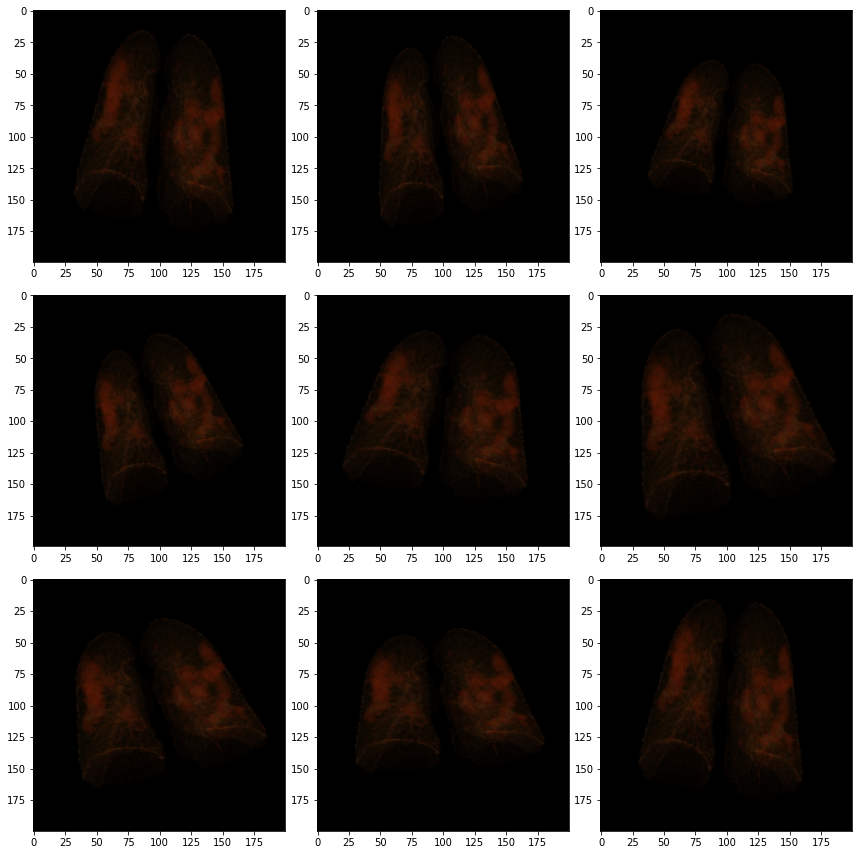

In [139]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = get_data_generator(example_df, "id", "label", class_mode = "categorical")
plt.figure(figsize = (12,12))
for i in range(0, 9):
        plt.subplot(3, 3, i+1)
        for X_batch, Y_batch in example_generator:
            image = X_batch[0]
            plt.imshow(image)
            break
plt.tight_layout()
plt.show()

In [140]:
def get_model():
    with tf.device('/GPU:0'):
#         inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
#         s = tf.keras.layers.Lambda(lambda x: x/255)(inputs)
        
        classifier = tf.keras.Sequential()

        classifier.add(tf.keras.layers.Conv2D(32, (3, 3), input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), activation= 'relu'))
        classifier.add(tf.keras.layers.MaxPooling2D((2, 2)))
#         classifier.add(MaxPooling2D(pool_size= (2,2)))

#         classifier.add(Convolution2D(64, (3, 3), activation= 'relu'))
        classifier.add(tf.keras.layers.Conv2D(64, (3, 3), activation= 'relu'))
        classifier.add(tf.keras.layers.MaxPooling2D((2, 2)))

        classifier.add(tf.keras.layers.Conv2D(128, (3, 3), activation= 'relu'))
        classifier.add(tf.keras.layers.MaxPooling2D((2, 2)))

        classifier.add(tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu'))
        classifier.add(tf.keras.layers.MaxPooling2D((2, 2)))

        classifier.add(tf.keras.layers.Conv2D(256, (3,3), activation = 'relu'))
        classifier.add(tf.keras.layers.MaxPooling2D((2, 2)))

        classifier.add(tf.keras.layers.Flatten())

        classifier.add(tf.keras.layers.Dense(units= 512, activation= 'relu'))
        classifier.add(tf.keras.layers.Dropout(0.2))
        classifier.add(tf.keras.layers.Dense(units= 3, activation= 'sigmoid'))

        classifier.compile(optimizer= 'adam', loss= 'categorical_crossentropy' ,metrics= ['accuracy'])
        classifier.summary()

        return(classifier, 'simple')

In [141]:
def get_model_alexnet():
    with tf.device('/GPU:0'):
        model = tf.keras.Sequential()

        model.add(tf.keras.layers.Conv2D(96, kernel_size=(11,11), strides= 4, padding= 'valid', activation= 'relu', 
                                         input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), kernel_initializer= 'he_normal'))
        
        model.add(tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides= (2,2), padding= 'valid', 
                                               data_format= None))

        model.add(tf.keras.layers.Conv2D(256, kernel_size=(5,5), strides= 1, padding= 'same', activation= 'relu',
                                         kernel_initializer= 'he_normal'))
        
        model.add(tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides= (2,2), padding= 'valid', 
                                               data_format= None)) 

        model.add(tf.keras.layers.Conv2D(384, kernel_size=(3,3), strides= 1, padding= 'same', activation= 'relu',
                                         kernel_initializer= 'he_normal'))

        model.add(tf.keras.layers.Conv2D(384, kernel_size=(3,3), strides= 1, padding= 'same', activation= 'relu',
                                         kernel_initializer= 'he_normal'))

        model.add(tf.keras.layers.Conv2D(256, kernel_size=(3,3), strides= 1, padding= 'same', activation= 'relu',
                                         kernel_initializer= 'he_normal'))

        model.add(tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides= (2,2), padding= 'valid', 
                                               data_format= None))

        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dense(4096, activation= 'relu'))
        model.add(tf.keras.layers.Dense(4096, activation= 'relu'))
        model.add(tf.keras.layers.Dense(1000, activation= 'relu'))
        model.add(tf.keras.layers.Dense(units=3, activation= 'softmax'))

        model.compile(optimizer= tf.keras.optimizers.Adam(0.001), loss='categorical_crossentropy', 
                      metrics=['accuracy'])
        
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        model.summary()
        return(model, 'alexnet')

In [142]:
def get_model_vgg16():
        with tf.device('/GPU:0'):
            conv_base = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

            conv_base.trainable = True
            set_trainable = False
            for layer in conv_base.layers:
                if layer.name == 'conv3_block1_1_conv':
                    set_trainable = True
                if set_trainable:
                    layer.trainable = True
                else:
                    layer.trainable = False

            model = tf.keras.Sequential()
            model.add(conv_base)
            model.add(tf.keras.layers.GlobalAveragePooling2D())
            model.add(tf.keras.layers.Dense(units=3, activation = 'sigmoid'))

            model.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['accuracy'])
            model.summary()
            return (model, 'vgg16')

In [143]:
def train_model(model, train_df, validation_df, epochs, callbacks=[]):
    batch_size = 16
    train_generator = get_data_generator(train_df, "id", "label", batch_size=batch_size, class_mode="categorical")
    validation_generator = get_data_generator(validation_df, "id", "label", batch_size=batch_size, class_mode="categorical")

    step_size_train = train_generator.n // train_generator.batch_size
    step_size_validation = validation_generator.n // validation_generator.batch_size

    if step_size_train == 0:
        step_size_train = train_generator.n // 2
        step_size_validation = validation_generator.n // 2
        
    history = model.fit(train_generator, # X_Train
        steps_per_epoch=step_size_train,
        epochs=epochs, 
        validation_data=validation_generator,
        validation_steps=step_size_validation,
        callbacks=callbacks
   )
    return history.history

In [144]:
# model, SELECTED_MODEL = get_model()
model, SELECTED_MODEL = get_model_alexnet()
# model, SELECTED_MODEL = get_model_vgg16()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_45 (Conv2D)           (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 97, 97, 64)        18496     
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 46, 46, 128)       73856     
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 23, 23, 128)       0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 21, 21, 128)      

In [ ]:
history = train_model(model, train_df, validation_df, EPOCHS)

Found 1632 validated image filenames belonging to 3 classes.
Found 306 validated image filenames belonging to 3 classes.
Epoch 1/50
102/102 [==============================] - 48s 472ms/step - loss: 0.4912 - accuracy: 0.7800 - val_loss: 0.7653 - val_accuracy: 0.7039
Epoch 2/50
102/102 [==============================] - 15s 146ms/step - loss: 0.0682 - accuracy: 0.9804 - val_loss: 1.0467 - val_accuracy: 0.7039
Epoch 3/50
102/102 [==============================] - 15s 147ms/step - loss: 0.0039 - accuracy: 0.9988 - val_loss: 0.8839 - val_accuracy: 0.7500
Epoch 4/50
102/102 [==============================] - 15s 146ms/step - loss: 0.0108 - accuracy: 0.9957 - val_loss: 1.4406 - val_accuracy: 0.6743
Epoch 5/50
102/102 [==============================] - 15s 147ms/step - loss: 0.0777 - accuracy: 0.9810 - val_loss: 2.7107 - val_accuracy: 0.6711
Epoch 6/50
102/102 [==============================] - 15s 147ms/step - loss: 0.0818 - accuracy: 0.9810 - val_loss: 5.1348 - val_accuracy: 0.6645
Epoch 7/5

In [ ]:
def plot_results(history):
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']

    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and Validation accuracy')
    plt.legend()
    plt.savefig('images/' + FOLDER_TEST + '/' + SUB_FILE + '/acc_wozsf21_'  + SELECTED_MODEL,
                pad_inches=0.1)
    
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.legend()
    
    plt.savefig('images/' + FOLDER_TEST + '/' + SUB_FILE + '/loss_wozsf21_'  + SELECTED_MODEL, 
                orientation='portrait', pad_inches=0.1)

    plt.show()

In [ ]:
plot_results(history)